In [16]:
import warnings
warnings.simplefilter('ignore')

In [2]:
import scanpy as sc
import pandas as pd
import numpy as np
import distanX

import cv2
import matplotlib.pyplot as plt

In [9]:
!wget https://cf.10xgenomics.com/samples/spatial-exp/3.0.0/Visium_HD_Mouse_Brain/Visium_HD_Mouse_Brain_binned_outputs.tar.gz
!tar -xzvf Visium_HD_Mouse_Brain_binned_outputs.tar.gz

Note: To read visium HD SpaceRanger output directly, `pyarrow` and `fastparquet` are  demanded. 

In [3]:
tissue_position_df = pd.read_parquet('./binned_outputs/square_008um/spatial/tissue_positions.parquet')
tissue_position_df.to_csv('./binned_outputs/square_008um/spatial/tissue_positions_list.csv', index=False, header=None)

library_id = 'brain'

adata = sc.read_visium('./binned_outputs/square_008um', library_id=library_id)
adata.var_names_make_unique()

## load hand-drawn regions

We use line segments to approximate the regions' contours.  
For now we can adjust approximate precision only, on `epsilon_factor`.

In [4]:
c2l_i1 = distanX.Curve2Line()
img_ROI1 = './tissue_hires_image_ROI1_mask.png'

c2l_i1.load_and_preprocess(img_ROI1)
c2l_i1.detect_contours()
c2l_i1.approximate_contours(epsilon_factor=0.001)

True

Now let's take a glance at the ROI and the hand-drawn iamge.

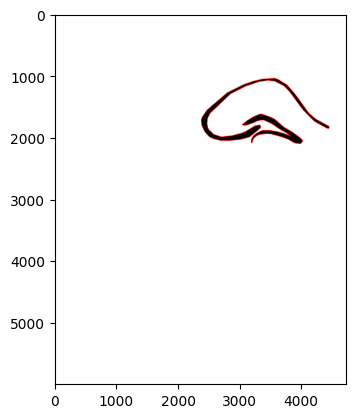

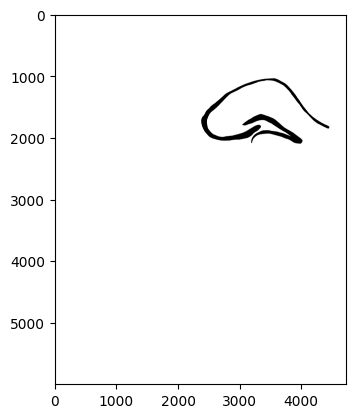

In [5]:
line_img = c2l_i1.image.copy()
for segment in c2l_i1.line_segments:
    cv2.polylines(line_img, [np.array(segment['points'])], True, (0, 0, 255), 10)
line_img = cv2.cvtColor(line_img, cv2.COLOR_BGR2RGB)

plt.imshow(line_img)
plt.show()
plt.imshow(c2l_i1.image)
plt.show()

## export hand-drawn regions to ROI in adata

In [6]:
l2r_i1 = distanX.Line2ROI()
l2r_i1.load_adata(adata)

It's necessary to match the scales of the hand_drawn image and the coordinate system of adata, like the images stored in adata.

You can set `image_path` only, and `Line2ROI.set_scalefactor` would find first library and scale factor of the hires image.  
Otherwise, you could set `override_scalefactor` parameter, which will overwrite the scale factor directly.

In [7]:
l2r_i1.set_scalefactor(image_path=img_ROI1, library_id=library_id, reference_image_key='hires')

Now name ROI 1, and add its information to adata, which would be in `adata.obs['ROI_'+name]` with values 'True' and 'False'.

In [8]:
ROI1_name = 'ROI1'

l2r_i1.append_polygons(c2l_i1.extract_polygons(),ROI1_name)
l2r_i1.set_adata_ROI(ROI1_name)

AnnData object with n_obs × n_vars = 393543 × 19059
    obs: 'in_tissue', 'array_row', 'array_col', 'ROI_ROI1'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

Now let's take a glance at the ROI again.

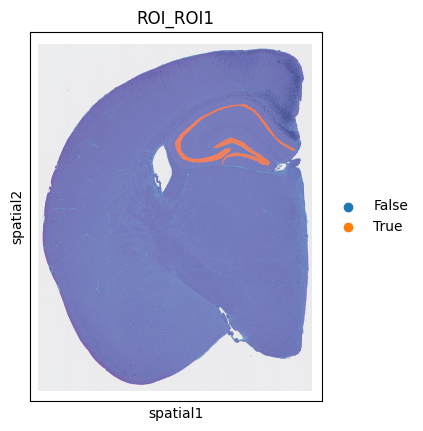

In [10]:
sc.pl.spatial(adata, color=['ROI_'+ROI1_name])

## add another ROI

Now everything is ready to calculate group spatial distance, if you've got a group in `adata.obs` such as `adata.obs['celltype']`. But let's set another ROI instead.

In [11]:
c2l_i2 = distanX.Curve2Line()
img_ROI2 = './tissue_hires_image_ROI2_mask.png'

c2l_i2.load_and_preprocess(img_ROI2)
c2l_i2.detect_contours()
c2l_i2.approximate_contours(epsilon_factor=0.001)

True

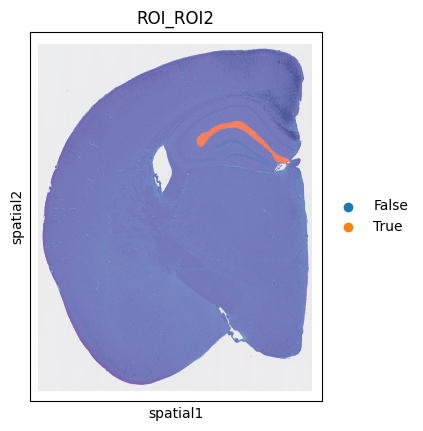

In [12]:
l2r_i2 = distanX.Line2ROI()
l2r_i2.load_adata(adata)
l2r_i2.set_scalefactor(img_ROI2)

ROI2_name = 'ROI2'
l2r_i2.append_polygons(c2l_i2.extract_polygons(),ROI2_name)
l2r_i2.set_adata_ROI(ROI2_name)

sc.pl.spatial(adata, color=['ROI_'+ROI2_name])

## calculate group spatial distance

The calculattion of distance matrix support parallel. You can set `n_jobs` when instantiate.

In [13]:
cd=distanX.CloudDistance(n_jobs=10)

The default method of calculating distance between two points is Euclidean distance, which can be replaced.

Here is a example of how to set a distance calculation function (but still Euclidean).

In [14]:
def pp_distance_function(x1: float, y1: float, x2: float, y2: float) -> float:
        return np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)

cd.set_pp_distance_function(pp_distance_function)

Now calculate the distance matrix, rownames are 1st group and colnames are 2nd group as set in parameters.  
Note that one `class_name` will be set as 'True' if it's not set and is None, which stand for the ROI.

Otherwise, you could calculate distance from a defined group to ROI, 2 defined groups, etc. Like follow:
```python
cd.compute_distance_matrix(adata,class_key_1='celltype',class_name_1='Neuron',class_key_2='ROI_ROI2',class_name_2='True')
```

In [17]:
cd.compute_distance_matrix(adata,class_key_1='ROI_ROI1',class_key_2='ROI_ROI2',class_name_2='True')

,s_008um_00224_00345-1,s_008um_00213_00344-1,s_008um_00226_00191-1,s_008um_00255_00164-1,s_008um_00213_00340-1,s_008um_00183_00254-1,s_008um_00231_00337-1,s_008um_00197_00227-1,s_008um_00213_00209-1,s_008um_00207_00224-1,...,s_008um_00189_00243-1,s_008um_00266_00166-1,s_008um_00269_00146-1,s_008um_00187_00234-1,s_008um_00200_00303-1,s_008um_00251_00167-1,s_008um_00258_00163-1,s_008um_00190_00251-1,s_008um_00216_00329-1,s_008um_00180_00241-1
s_008um_00255_00386-1,1501.137871,1734.663551,5757.722131,6483.423706,1819.155714,4391.479796,1593.466566,4943.133846,5312.995987,4934.703323,...,4599.907411,6432.920376,7020.940060,4863.406465,2907.982956,6396.906985,6513.190299,4376.090664,2017.058827,4767.944750
s_008um_00261_00228-1,3583.316032,3665.784958,1487.641791,1877.498866,3558.129230,2400.638272,3301.346312,1869.073720,1507.656359,1581.187912,...,2147.447550,1816.655950,2406.277776,2167.877418,2822.740396,1805.492886,1900.503768,2179.120522,3228.715067,2395.399149
s_008um_00261_00300-1,1700.966013,1901.135576,3343.761572,3975.920500,1824.245932,2644.664350,1390.780281,2835.559110,3005.040211,2723.086100,...,2682.082682,3916.254120,4503.726184,2896.075605,1783.289051,3895.434932,4002.194819,2519.514696,1563.021616,2926.770123
s_008um_00256_00247-1,3010.386554,3098.221603,1855.648467,2424.343408,2991.807017,2141.339081,2727.642200,1819.344924,1676.086000,1580.863007,...,1959.951613,2383.594338,2974.098322,2050.423083,2312.327551,2341.141516,2454.040050,1930.719924,2664.067493,2226.205619
s_008um_00241_00396-1,1569.978122,1724.817221,6003.009171,6787.640371,1828.512036,4479.889069,1747.569518,5100.329944,5522.272908,5120.538310,...,4719.555832,6756.343367,7346.560046,4987.333312,2968.335646,6694.107545,6822.578612,4489.175852,2088.488281,4864.940791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
s_008um_00254_00240-1,3188.841298,3264.316760,1648.453791,2219.901668,3155.935605,2113.029070,2911.130134,1707.312868,1501.273490,1449.946830,...,1900.022099,2189.405056,2780.036883,1964.329896,2422.735067,2133.925387,2251.918271,1896.130544,2825.802384,2161.029403
s_008um_00272_00330-1,1468.264069,1770.448845,4276.363543,4873.598386,1747.211365,3418.132372,1214.407758,3721.402228,3931.868863,3631.726658,...,3511.879091,4792.928992,5374.572019,3745.018529,2245.565994,4799.997988,4894.531491,3325.576474,1635.399030,3738.588149
s_008um_00246_00221-1,3677.694614,3718.858986,1053.169095,1685.334839,3606.163841,2076.526483,3415.794025,1441.466825,1025.495970,1142.161782,...,1783.947637,1709.070025,2290.979210,1764.057712,2745.409318,1583.878755,1729.759585,1854.912040,3273.229935,2013.632157
s_008um_00234_00299-1,1374.634563,1449.996503,3162.937420,3990.010693,1345.051369,1986.517957,1113.157617,2364.428904,2699.279341,2328.217529,...,2098.307174,3994.897250,4583.605582,2342.860968,999.599152,3886.854956,4033.139606,1901.866410,1021.527614,2314.621715


Also, the method of calculating distance between a point in a class and all points in another class could be customized. the customized function should work on a 1d array, as it's expected to run on each row of the distance matrix.

The default method is for every point in the class set in `on` parameter in `CloudDistance.compute_cloud_distance`, find the minimal distance to another class.  
Anyway let's set it again.

In [18]:
cd.set_cloud_distance_function('min')
# equal to
# cd.set_cloud_distance_function(np.min)

Set `on` as 'class_1' makes the funtion find min of each row. That means the minimal distances from each point in class 1 to the whole class 2. This return an array with same size of class 1.

In [20]:
distances = cd.compute_cloud_distance(on='class_1')

We can visualize the result. Most distances range 800px to 1200px.

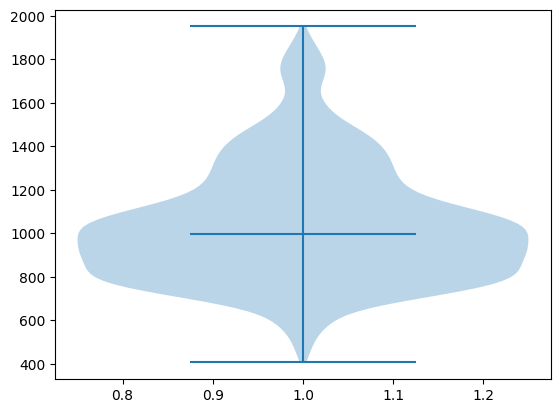

In [26]:
plt.violinplot(distances, showmedians=True)
plt.show()

And the mean minimal distance.

In [27]:
np.mean(distances)

1039.7167634549967